<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Traveling sales person

## Contents

In this notebook, we will learn

- How to parallelize the solution of the traveling sales person problem
- The concept of search overhead


## The traveling sales person (TSP) problem

Let us start by presenting the [traveling sales person (ASP) problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) and its solution using a [branch and bound algorithm](https://en.wikipedia.org/wiki/Branch_and_bound).

### Problem statement

- Given a graph $G$ with a distance table $C$ and an initial node (i.e. a city) in the graph
- Compute the shortest route that visits all cities exactly once, without returning to the initial city.


Note that there we consider a version of the problem in which do not return to the initial city. However, the classic version of the problem includes returning to the initial city.


As for the ASP problem we represent the distance table as a matrix, where $C_{ij}$ is the distance from node $i$ to node $j$. Next figure shows the input and solution (output) of the TSP problem for a simple 4-node graph. 

<div>
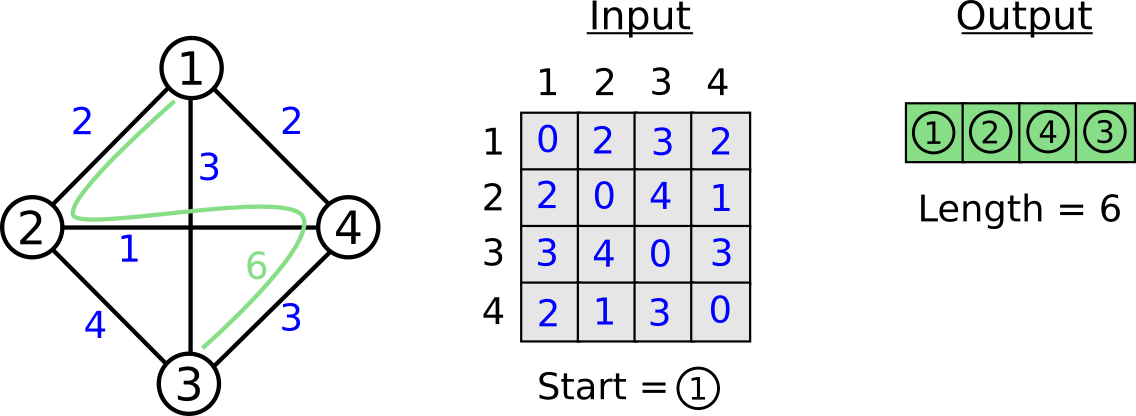
</div>
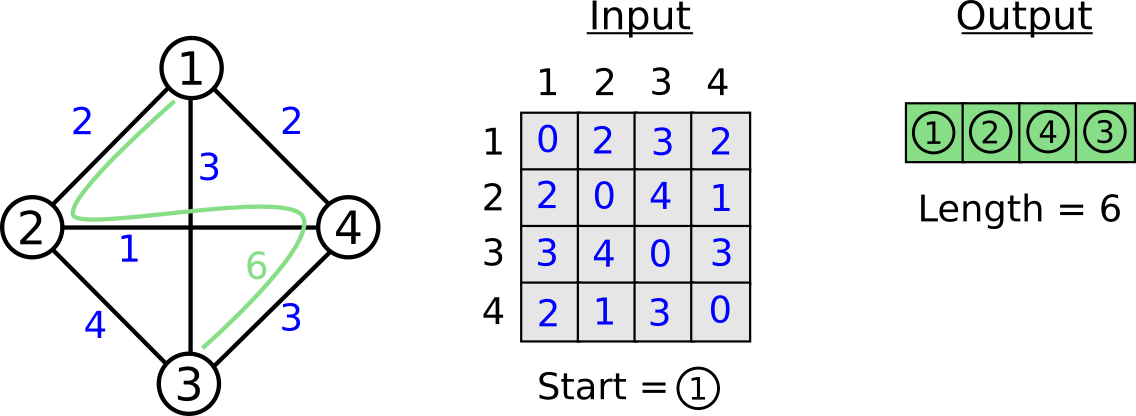

### Branch and bound algorithm

We consider a [branch and bound strategy](https://en.wikipedia.org/wiki/Branch_and_bound) to solve the ASP problem. The first ingredient of this strategy is to enumerate all potential solutions of the problem using a search tree. The tree is defined as follows:

- The root is the initial city
- The children of a node are the neighbor cities not visited so-far
- **We sort the children using the nearest city first heuristic**
- A node will be a leaf of the tree when all neighbor cities are already visited


The nearest city first heuristic is a way to speed up the search as we increase the possibility of finding the solution in the first paths enumerated in the tree.

<div>
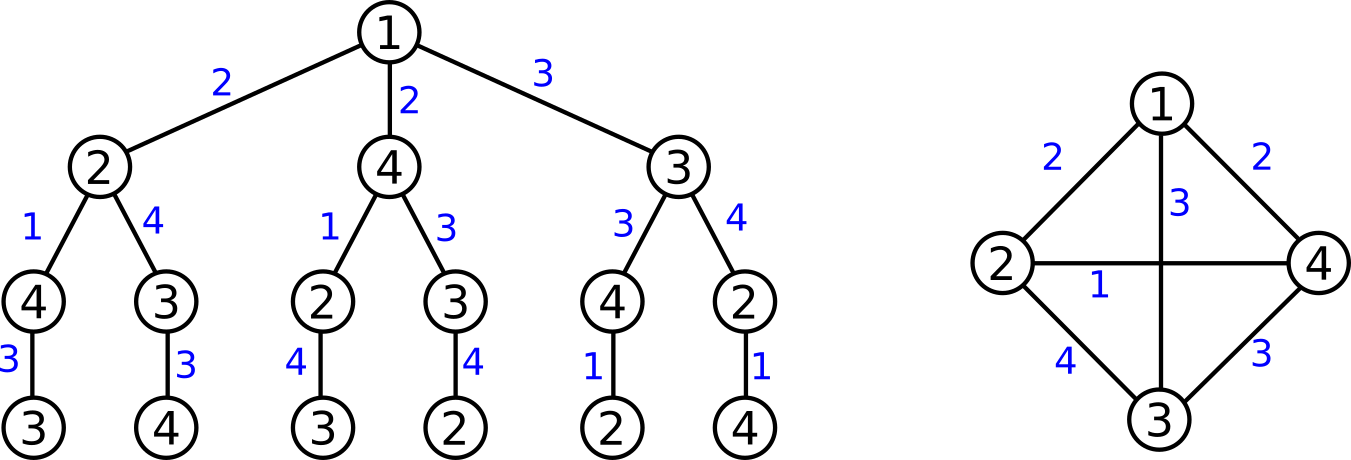
</div>
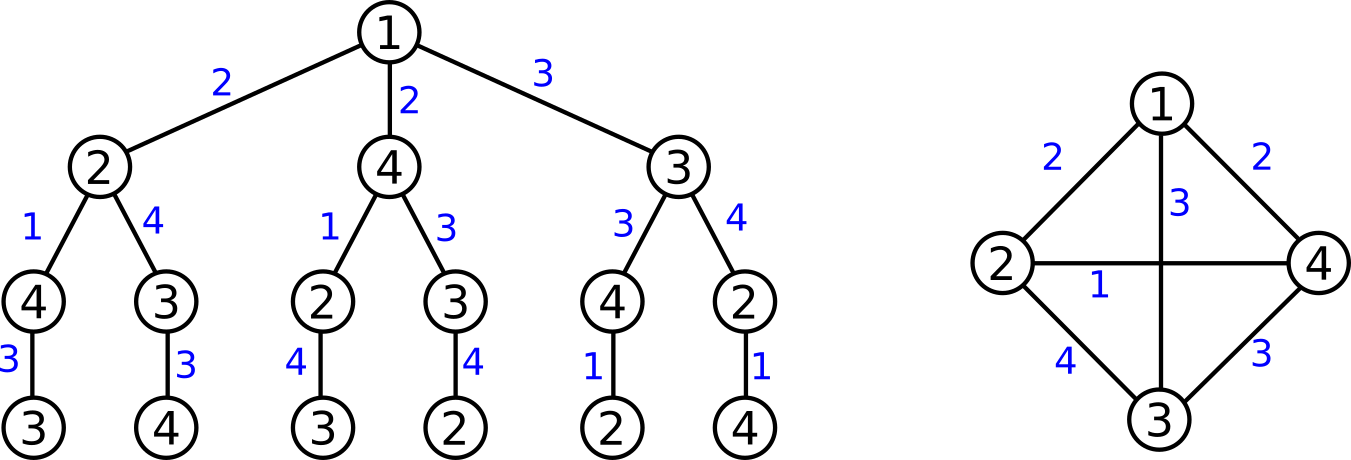

### Pruning the search tree

We look for a solution by going over the branches of the search tree via first-depth search. Each time we hit a lead in the tree we have a route between all cities and this a possible solution of the TSP problem (called a partial solution). In this process, we keep track of which is the shortest partial solution found so far. Note that we don't need to completely traverse all branches. In some cases, the distance at an intermediate point in a route will be already equal or greater than the best distance found so-far. In this case, we don't need to continue moving within this branch and we can jump to the next one. This is the "bound" criterion in our branch and bound strategy, which is also referred to as "pruning" the search tree.

In the example below, the first route has distance 6. At an intermediate point of the 2nd route we have already covered a distance equal to 6 which guarantees that the solution will not be in this part of the tree.


<div>
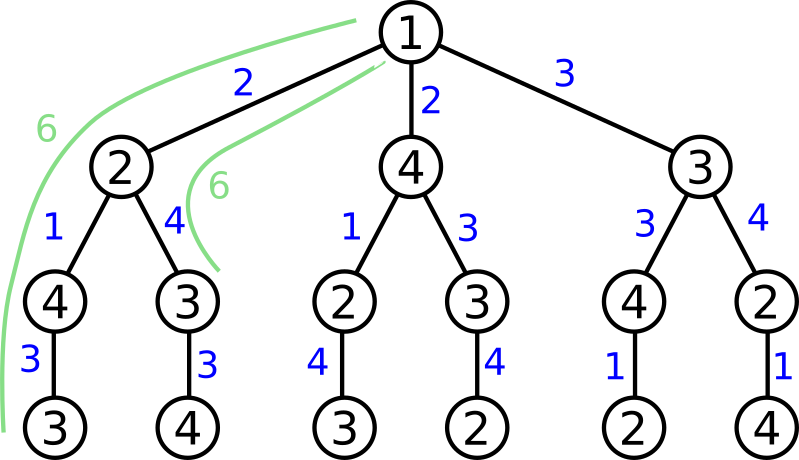
</div>
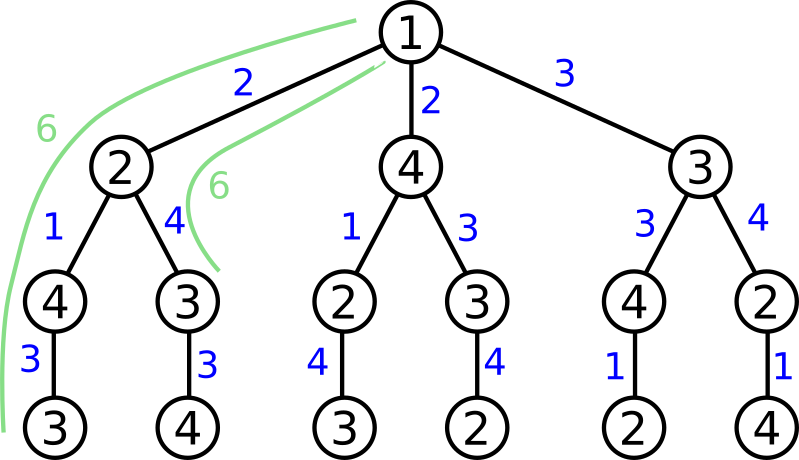

Thus, there are only 2 more complete routes that we need to visit. Using this strategy we have significantly reduced the routes visited: from 6 possible routes to 3 visited routes.

<div>
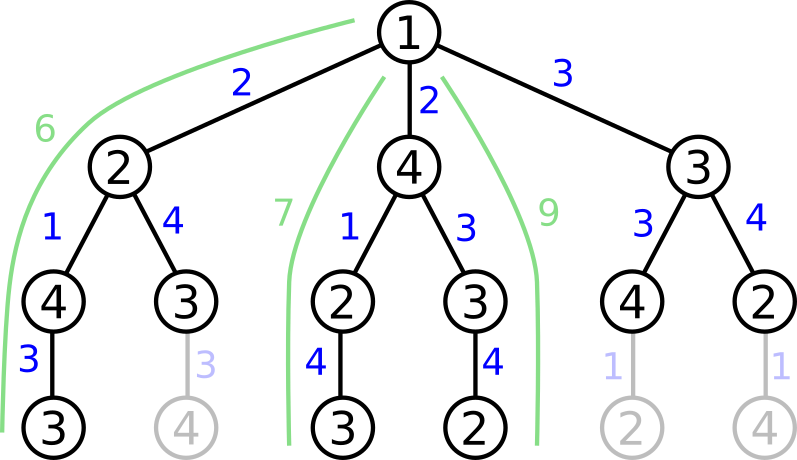
</div>
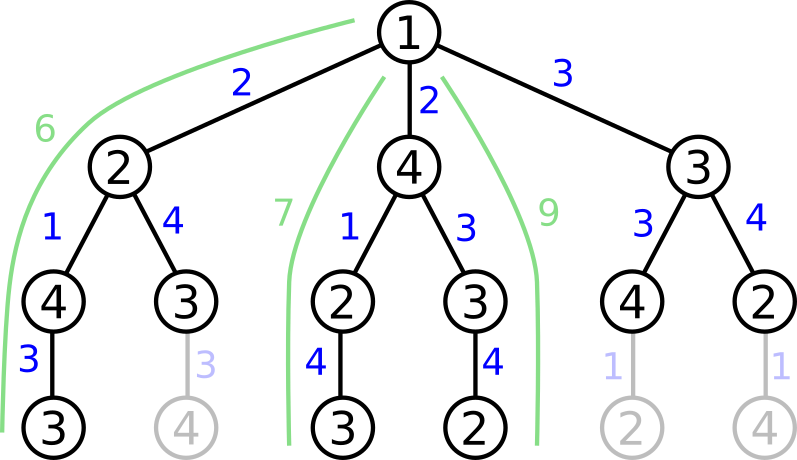

## Serial implementation

### Input distance

In [1]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]

4×4 Matrix{Int64}:
 0  2  3  2
 2  0  4  1
 3  4  0  3
 2  1  3  0

In [24]:
C = [
    [(1,0), (2,2), (3,3), (4,4)],
    [(2,0), (4,1), (1,2), (3,3)],
    [(3,0), (1,3), (2,3), (4,10)], 
    [(4,0), (2,1), (1,4), (3,10)]
]

4-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 0), (2, 2), (3, 3), (4, 4)]
 [(2, 0), (4, 1), (1, 2), (3, 3)]
 [(3, 0), (1, 3), (2, 3), (4, 10)]
 [(4, 0), (2, 1), (1, 4), (3, 10)]

### Nearest-city first heuristic

In [2]:
function sort_neighbors(C)
    n = size(C,1)
    map(1:n) do i
        Ci = C[i,:]
        cities = sortperm(Ci)
        distances = Ci[cities]
        collect(zip(cities,distances))[2:end]
    end
end

sort_neighbors (generic function with 1 method)

In [ ]:
connections = sort_neighbors(C)

### Implementation

In [25]:
function tsp_serial(C,city)
    #connections = sort_neighbors(C)
    num_cities = length(connections)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance = 0
    min_distance = typemax(Int)
    tsp_serial_recursive!(connections,hops,path,distance,min_distance)
end
function tsp_serial_recursive!(connections,hops,path,distance,min_distance)
    num_cities = length(connections)
    if hops == num_cities
        min_distance = min(distance,min_distance)
        @show path, distance, min_distance
        return min_distance
    else
        next_hops = hops + 1
        current_city = path[hops]
        for (next_city,distance_increment) in connections[current_city]
            if !visited(next_city,hops,path)
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                if next_distance < min_distance
                    min_distance = tsp_serial_recursive!(connections,next_hops,path,next_distance,min_distance)
                end
            end
        end        
    end
    return min_distance
end
function visited(city,hops,path)
    for i = 1:hops
        if path[i] == city
            return true
        end
    end
    return false
end

city = 1
tsp_serial(C,city)

(path, distance, min_distance) = ([1, 2, 4, 3], 13, 13)
(path, distance, min_distance) = ([1, 3, 2, 4], 7, 7)


7

In [ ]:
function tsp_serial(C,city)
    connections = sort_neighbors(C)
    num_cities = length(connections)
    current_route = (;path=zeros(Int,num_cities),distance=Ref(0))
    min_route = (;path=zeros(Int,num_cities),distance=Ref(typemax(Int)))
    hops = 1
    current_route.path[hops] = city
    tsp_serial_recursive!(connections,hops,current_route,min_route)
    min_route
end
function tsp_serial_recursive(connections,hops,current_route,min_route)
    num_cities = length(connections)
    if hops == num_cities
        if current_route.distance < min_route.distance
            min_route.path .= current_route.path
            min_route.distance[] = current_route.distance 
            return
        end
    else
        next_hops = hops + 1
        current_city = current_route.path[hops]
        for (next_city,distance_increment) in connections[current_city]
            if !visited(next_city,hops,current_route.path)
                
                next_distance = current_distance + distance_increment
                
                if next_distance < min_distance
                    return tsp_serial_recursive(connections,hops+1,current_route,min_route)
                end
            end
        end        
    end
    min_distance
end

function visited(city,hops,path)
    for i = 1:hops
        if path[i] == city
            return true
        end
    end
    return false
end

city = 1
tsp_serial(C,city)

### Generating some test data

The following function generates a random symmetric distance matrix, we have used a large. Note that the TSP problem at least requires that the underlying graph is connected (otherwise there is no route that visits all nodes). The next function does not guarantee this. In any case, we can still used a non-connected graph as input. The outcome of the search will be that there is no possible route.

In [ ]:
function rand_symmetric_distance_table(n)
  threshold = 0.2
  mincost = 3
  maxcost = 10
  infinity = 10000*maxcost
  C = fill(infinity,n,n)
  for j in 1:n
    for i in 1:j
      if rand() > threshold
        C[i,j] = rand(mincost:maxcost)
        C[j,i] = C[i,j]
      end
    end
    C[j,j] = 0
  end
  C,infinity
end

In [ ]:
n = 10000
C, inf = rand_symmetric_distance_table(n)
city = 1
(;path,distance) = tsp_serial(C,city)
if  distance >= inf
    println("The input graph is nonconnected")
else
    (;path,distance)
end

<div>
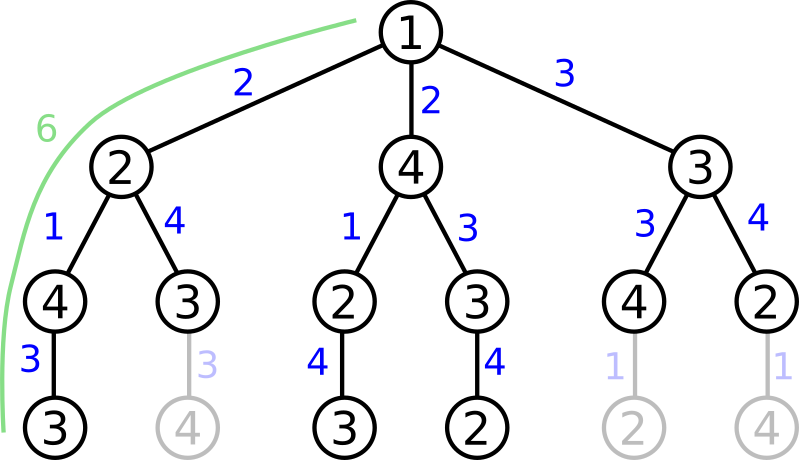
</div>
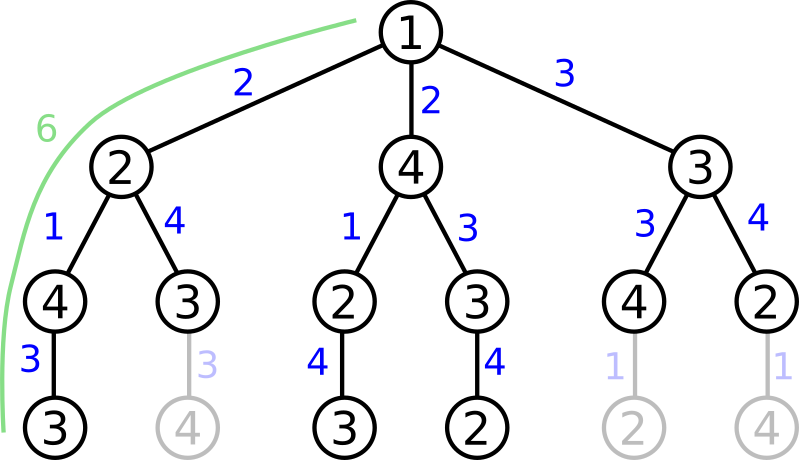

<div>
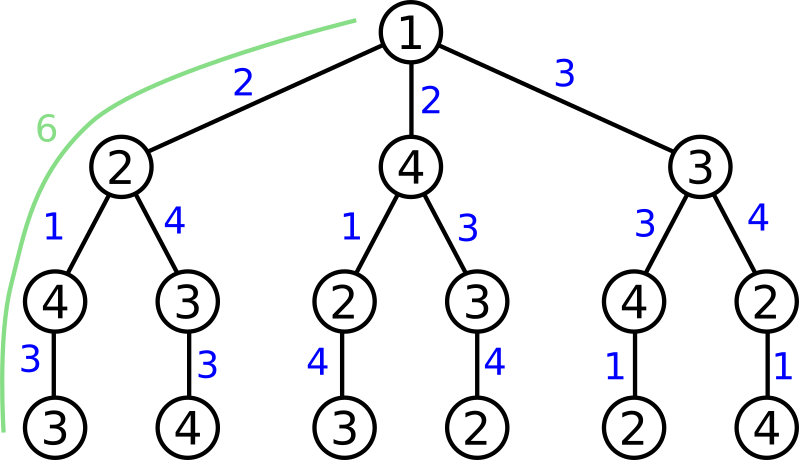
</div>
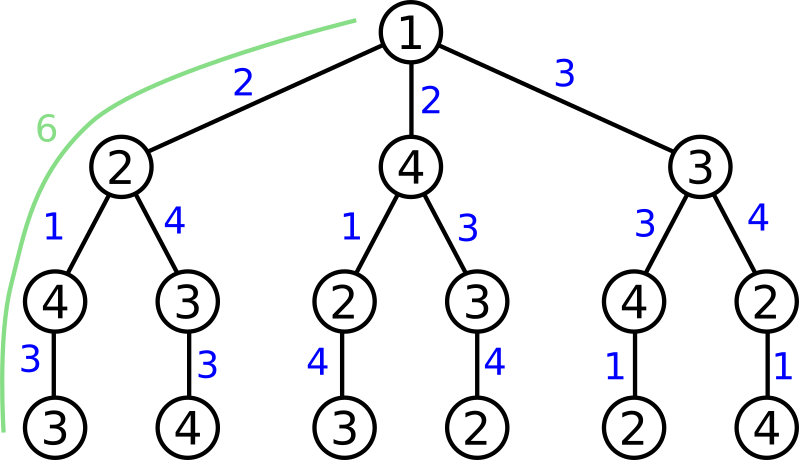

<div>
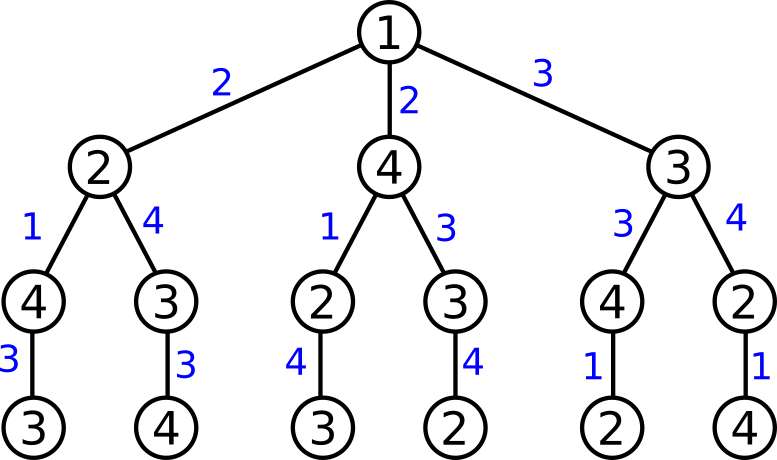
</div>
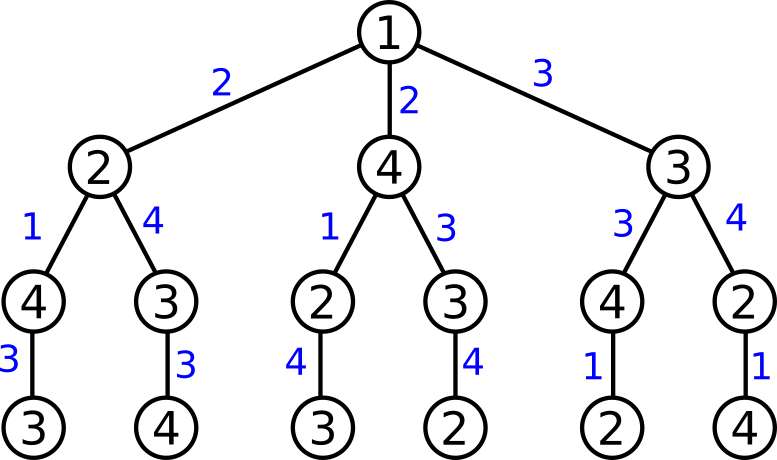

In [ ]:
using Distributed

In [ ]:
if procs() == workers()
    addprocs(4)
end

In [ ]:
@everywhere function visited(city,hops,path)
    for i = 1:hops
        if path[i] == city
            return true
        end
    end
    return false
end

In [ ]:
connections = [
    [(1,0),(4,39),(5,76), (6,78),(3,94),(2,97)],
    [(2,0),(5,25),(4,58),(3,62),(1,97),(6,109)],
    [(3,0),(6,58),(2,62),(4,68),(5,70),(1,94)],
    [(4,0),(5,38),(1,39),(2,58),(3,68),(6,78)],
    [(5,0),(2,25),(4,38),(3,70),(1,76),(6,104)],
    [(6,0),(3,58),(1,78),(4,78),(5,104),(2,109)]
]
city = 1
tsp_serial(connections,city)

In [ ]:
@everywhere function tsp_dist_impl(connections,hops,path,current_distance,min_distance,max_hops,jobs_chnl,ftr_result)
    num_cities = length(connections)
    if hops == num_cities
        if current_distance < min_distance
            if ftr_result !== nothing
                @spawnat 1 begin
                    result = fetch(ftr_result)
                    result.path .= path
                    result.min_distance_ref[] = current_distance
                end |> wait
            end
            return current_distance
        end
    elseif hops <= max_hops
        current_city = path[hops]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections[current_city]
            if !visited(next_city,hops,path)
                path[next_hops] = next_city
                next_distance = current_distance + distance_increment
                if next_distance < min_distance
                    return tsp_dist_impl(connections,next_hops,path,next_distance,min_distance,max_hops,jobs_chnl,ftr_result)
                end
            end
        end 
    else
        if jobs_chnl !== nothing
            put!(jobs_chnl,(;hops,path,current_distance))
        end
    end
    min_distance
end

function tsp_dist(connections,city)
    max_hops = 2
    num_cities = length(connections)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    current_distance = 0
    min_distance = typemax(Int)
    jobs_chnl = RemoteChannel(()->Channel{Any}(10))
    ftr_result = @spawnat 1 (;path,min_distance_ref=Ref(min_distance))
    task = @async begin
        tsp_dist_impl(connections,hops,path,current_distance,min_distance,max_hops,jobs_chnl,nothing)
        for w in workers()
            put!(jobs_chnl,nothing)
        end
    end
    @sync for w in workers()
        @spawnat w begin
            max_hops = typemax(Int)
            jobs_channel = nothing
            while true
                job = take!(jobs_chnl)
                if job == nothing
                    break
                end
                hops = job.hops
                path = job.path
                current_distance = job.current_distance
                tsp_dist_impl(connections,hops,path,current_distance,min_distance,max_hops,jobs_channel,ftr_result)
            end
        end
    end 
    result = fetch(ftr_result)
    (;path = result.path, distance = result.min_distance_ref[])
end
city = 1
tsp_dist(connections,city)